# **IELTS Writing Scores Analysis : Extracting Insights from Test Taker's Essays**


# **Business Understanding**

**Business Problems :**
Menentukan skor IELTS Writing sering kali subjektif dan dipengaruhi banyak faktor, seperti panjang esai, kompleksitas sintaksis, variasi tenses, serta kekayaan kosakata. Tanpa analisis kuantitatif, sulit memahami faktor apa yang paling kuat membedakan skor rendah vs tinggi.

**Business Objectives :**
Melakukan eksplorasi dataset IELTS Writing untuk menemukan pola dalam:
1. Distribusi skor antar task
2. Hubungan panjang esai dengan skor
3. Perbedaan penggunaan tenses, klausa, dan voice
4. Variasi kosakata antara skor rendah vs tinggi

Diharapkan insight tersebut dapat menjadi rujukan atas rekomendasi strategi pembelajaran writing bagi calon peserta IELTS.

# **API**

In [23]:
!pip install replicate
!pip install langchain_community

In [2]:
from google.colab import userdata
import os
api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token

In [3]:
def get_summarization_params(essay_text, summary_ratio=0.2, min_tokens=50, max_tokens_limit=300):
    """
    Membuat parameter summarization otomatis sesuai panjang essay.
    """
    import math
    word_count = len(essay_text.split())
    max_tokens = math.ceil(word_count * summary_ratio * 1.3)
    max_tokens = max(min_tokens, min(max_tokens, max_tokens_limit))
    return {
        "top_k": 5,
        "top_p": 1.0,
        "max_tokens": max_tokens,
        "min_tokens": min_tokens,
        "random_seed": None,
        "repetition_penalty": 1.1,
        "temperature": 0,  # deterministik
        "stopping_criteria": f"length ({max_tokens} tokens)",
        "stopping_sequence": None
    }

# **Data Understanding**

**Library**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

**Data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/ielts_writing_dataset.csv')
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Task_Type                                           Question  \
0          1  The bar chart below describes some changes abo...   
1          2  Rich countries often give money to poorer coun...   
2          1  The bar chart below describes some changes abo...   
3          2  Rich countries often give money to poorer coun...   
4          1  The graph below shows the number of overseas v...   

                                               Essay Examiner_Commen  \
0  Between 1995 and 2010, a study was conducted r...             NaN   
1  Poverty represents a worldwide crisis. It is t...             NaN   
2  The left chart shows the population change hap...             NaN   
3  Human beings are facing many challenges nowada...             NaN   
4  Information about the thousands of visits from...             NaN   

   Task_Response  Coherence_Cohesio

**Cek tipe data**

In [6]:
print(df.dtypes)

Task_Type               int64
Question               object
Essay                  object
Examiner_Commen        object
Task_Response         float64
Coherence_Cohesion    float64
Lexical_Resource      float64
Range_Accuracy        float64
Overall               float64
dtype: object


**Jumlah baris dan kolom**

In [7]:
print("Jumlah baris:", df.shape[0])
print("Jumlah kolom:", df.shape[1])

Jumlah baris: 1435
Jumlah kolom: 9


**Ringkasan statistik semua kolom**

In [8]:
print(df.info())
print(df.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Task_Type           1435 non-null   int64  
 1   Question            1435 non-null   object 
 2   Essay               1435 non-null   object 
 3   Examiner_Commen     62 non-null     object 
 4   Task_Response       0 non-null      float64
 5   Coherence_Cohesion  0 non-null      float64
 6   Lexical_Resource    0 non-null      float64
 7   Range_Accuracy      0 non-null      float64
 8   Overall             1435 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 101.0+ KB
None
          Task_Type                                           Question  \
count   1435.000000                                               1435   
unique          NaN                                                402   
top             NaN  Write about the following topic.The issue o

# **Exploratory Data Analysis**



**Cek missing values**

In [9]:
print(df.isnull().sum())

Task_Type                0
Question                 0
Essay                    0
Examiner_Commen       1373
Task_Response         1435
Coherence_Cohesion    1435
Lexical_Resource      1435
Range_Accuracy        1435
Overall                  0
dtype: int64


**Cek teks essay (jika tedapat karakter aneh)**

In [10]:
import re

def detect_non_ascii(text):
    return bool(re.search(r"[^\x00-\x7F]", str(text)))

non_ascii_rows = df[df["Essay"].apply(detect_non_ascii)]

print(f"Jumlah baris dengan karakter non-ASCII: {len(non_ascii_rows)}")
print("\nContoh baris dengan karakter aneh:")
print(non_ascii_rows["Essay"].head(10))

Jumlah baris dengan karakter non-ASCII: 202

Contoh baris dengan karakter aneh:
16     Information is presented in two pie charts whi...
39     There is currently a contentious argument that...
81     There is currently a contentious argument rega...
101    Over decades, there has been a belief that adu...
124    To my honest university:\nI will write a repor...
127    As the world has been experiencing rapidly agi...
136    The diagram illustrates how a solar panel is c...
137    While it is considered by some that young pupi...
140    The diagram below shows the life cycle of the ...
152    The maps illustrate the changes of an architec...
Name: Essay, dtype: object


**Cek outlier**

In [11]:
Q1 = df['Overall'].quantile(0.25)
Q3 = df['Overall'].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR

outliers = df[(df['Overall'] < lb) | (df['Overall'] > ub)]
print(f"Batas bawah = {lb}, batas atas = {ub}")
print("Jumlah outlier:", outliers.shape[0])
print(outliers[['Overall','Essay']].head())

Batas bawah = 4.5, batas atas = 8.5
Jumlah outlier: 56
    Overall                                              Essay
9       9.0  International sports events require the most w...
35      9.0  Many people believe that the most effective wa...
49      9.0  In today's era, most students look forward to ...
65      3.5  There is no denying the fact that the main pur...
76      4.0  This bar chart depicts the percentage between ...


**Perbandingan skor Overall berdasarkan Task_Type**

/tmp/ipython-input-1149688537.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_Type", y="Overall", data=df, palette="Set2")


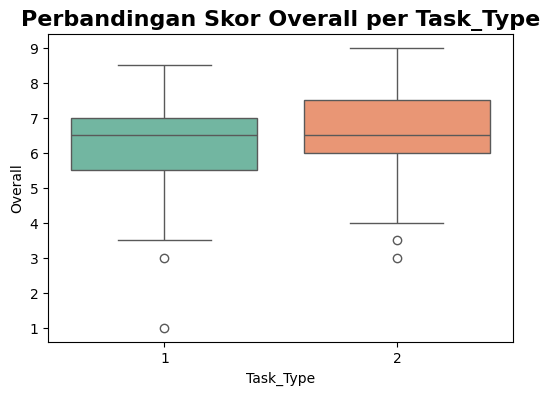

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Task_Type", y="Overall", data=df, palette="Set2")
plt.title("Perbandingan Skor Overall per Task_Type", size=16, weight="bold")
plt.show()


Perbandingan Skor antar Task_Type:
- Task 2 (argumentative essays) cenderung memiliki skor median lebih tinggi dibanding Task 1 (descriptive essays).
- Variasi skor di Task 2 juga lebih lebar.

**Distribusi nilai Overall**

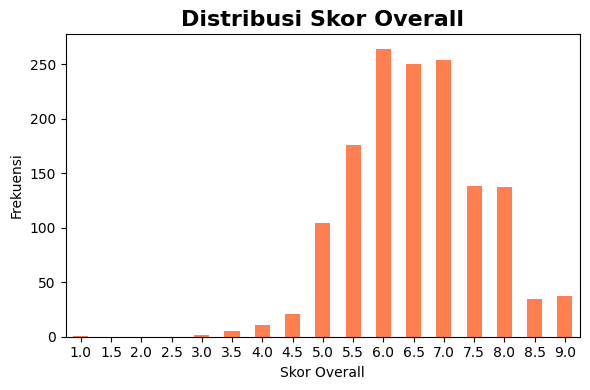

In [13]:
plt.figure(figsize=(6, 4))

all_scores = [i * 0.5 for i in range(2, 19)] # From 1.0 to 9.0
df['Overall_categorical'] = pd.Categorical(df['Overall'], categories=all_scores, ordered=True)
score_counts = df['Overall_categorical'].value_counts().sort_index()
score_counts.plot(kind="bar", color="coral")
plt.title("Distribusi Skor Overall", size=16, weight="bold")
plt.xlabel("Skor Overall")
plt.ylabel("Frekuensi")
plt.xticks(rotation=0) # Keep x-axis labels horizontal for readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

Distribusi Skor:
- Skor IELTS writing berkisar 1.0–9.0.
- Mayoritas skor terkonsentrasi di 5.0–7.0 (kategori menengah).
- Ada outliers (skor sangat rendah 1–3)

# **Data Preprocessing**

**Handling missing values**

In [14]:
missing_counts = df.isnull().sum()
total_rows = df.shape[0]

threshold = 0.5
cols_to_drop = [col for col in missing_counts.index if (missing_counts[col] / total_rows > threshold)]
print("Kolom yang akan dihapus karena >50% NaN:", cols_to_drop)

cols_to_drop_actual = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop_actual)

if 'Overall_categorical' in df.columns:
    df = df.drop(columns=['Overall_categorical'])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('No Comment')
    else:
        df[col] = df[col].fillna(0)

print(df.info())
print(df.head())

Kolom yang akan dihapus karena >50% NaN: ['Examiner_Commen', 'Task_Response', 'Coherence_Cohesion', 'Lexical_Resource', 'Range_Accuracy']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Task_Type  1435 non-null   int64  
 1   Question   1435 non-null   object 
 2   Essay      1435 non-null   object 
 3   Overall    1435 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 45.0+ KB
None
   Task_Type                                           Question  \
0          1  The bar chart below describes some changes abo...   
1          2  Rich countries often give money to poorer coun...   
2          1  The bar chart below describes some changes abo...   
3          2  Rich countries often give money to poorer coun...   
4          1  The graph below shows the number of overseas v...   

                                             

**Handling text essay (untuk beberapa karakter aneh)**

In [15]:
import re
def clean_text(text):
    """Removes non-ASCII characters from a string."""
    return re.sub(r"[^\x00-\x7F]+", "", str(text))

df['Essay_clean'] = df['Essay'].apply(clean_text)

non_ascii_cleaned = df[df['Essay_clean'].apply(detect_non_ascii)]
print(f"\nJumlah baris dengan karakter non-ASCII setelah cleaning: {len(non_ascii_cleaned)}")
print("\nContoh hasil pembersihan:")
print(df[['Essay','Essay_clean']].head(5))


Jumlah baris dengan karakter non-ASCII setelah cleaning: 0

Contoh hasil pembersihan:
                                               Essay  \
0  Between 1995 and 2010, a study was conducted r...   
1  Poverty represents a worldwide crisis. It is t...   
2  The left chart shows the population change hap...   
3  Human beings are facing many challenges nowada...   
4  Information about the thousands of visits from...   

                                         Essay_clean  
0  Between 1995 and 2010, a study was conducted r...  
1  Poverty represents a worldwide crisis. It is t...  
2  The left chart shows the population change hap...  
3  Human beings are facing many challenges nowada...  
4  Information about the thousands of visits from...  


**Flag Outlier**

Batas bawah = 4.5, batas atas = 8.5
Jumlah outlier: 56
    Overall                                              Essay
9       9.0  International sports events require the most w...
35      9.0  Many people believe that the most effective wa...
49      9.0  In today's era, most students look forward to ...
65      3.5  There is no denying the fact that the main pur...
76      4.0  This bar chart depicts the percentage between ...


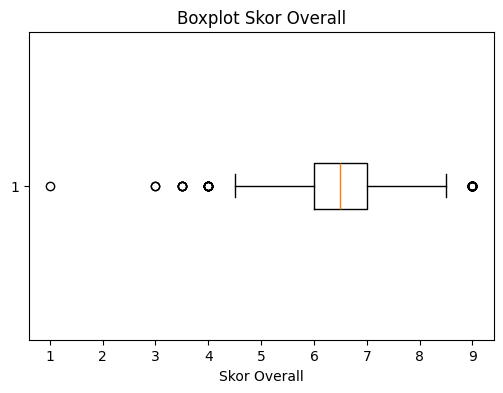

In [16]:
df['is_outlier'] = (df['Overall'] < lb) | (df['Overall'] > ub)

outliers = df[df['is_outlier']]
print(f"Batas bawah = {lb}, batas atas = {ub}")
print(f"Jumlah outlier: {outliers.shape[0]}")
print(outliers[['Overall','Essay']].head())

plt.figure(figsize=(6,4))
plt.boxplot(df['Overall'], vert=False)
plt.title("Boxplot Skor Overall")
plt.xlabel("Skor Overall")
plt.show()

# **Feature Engineering**

**Analisis panjang essay**

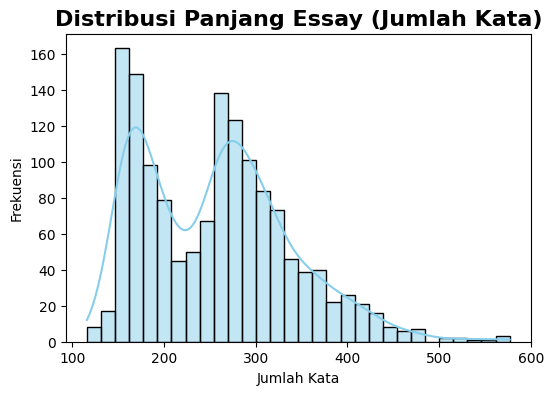

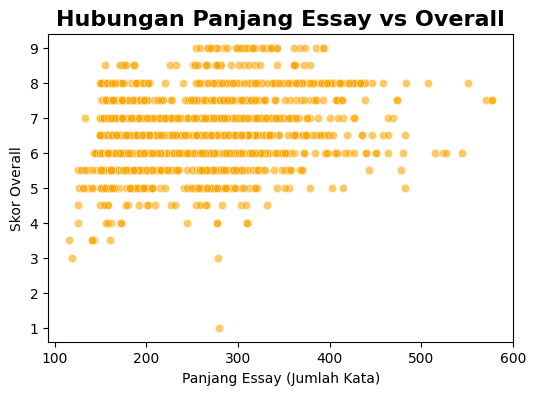

In [17]:
df["essay_length"] = df["Essay"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(df["essay_length"], bins=30, kde=True, color="skyblue")
plt.title("Distribusi Panjang Essay (Jumlah Kata)", size=16, weight="bold")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x="essay_length", y="Overall", data=df, alpha=0.6, color="orange")
plt.title("Hubungan Panjang Essay vs Overall", size=16, weight="bold")
plt.xlabel("Panjang Essay (Jumlah Kata)")
plt.ylabel("Skor Overall")
plt.show()

Panjang Essay:
- Panjang essay umumnya 150–350 kata.
- Korelasi positif terlihat: semakin panjang essay → cenderung skor lebih tinggi (tapi tidak selalu linear).

**Distribusi jenis tenses yang digunakan**

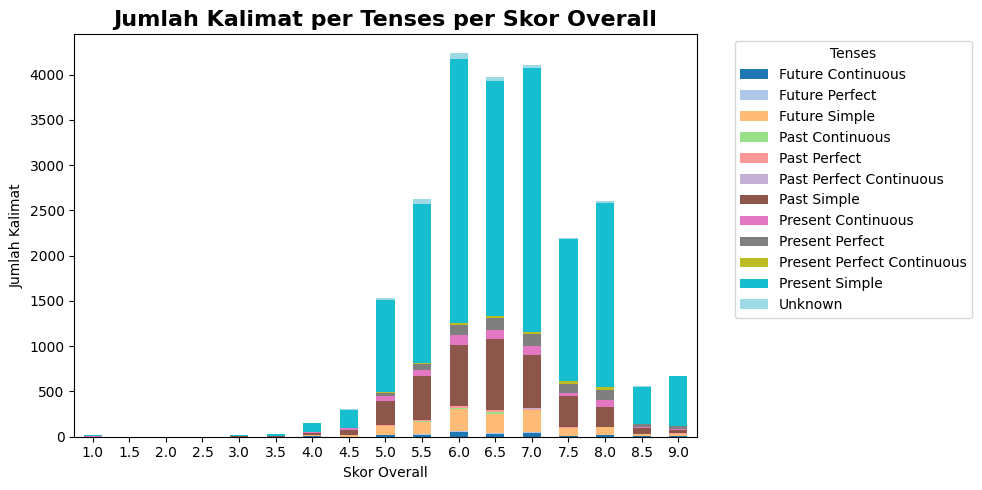

In [18]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

def detect_tense(doc):
    tenses = []
    tokens = [t.text.lower() for t in doc]
    tags = [t.tag_ for t in doc]

    for i, token in enumerate(doc):
        # Present Simple
        if token.tag_ in ["VB", "VBP", "VBZ"]:
            tenses.append("Present Simple")
        # Present Continuous
        if token.text.lower() in ["am", "is", "are"] and i+1 < len(doc) and doc[i+1].tag_ == "VBG":
            tenses.append("Present Continuous")
        # Present Perfect
        if token.text.lower() in ["have", "has"] and i+1 < len(doc) and doc[i+1].tag_ == "VBN":
            tenses.append("Present Perfect")
        # Present Perfect Continuous
        if token.text.lower() in ["have", "has"] and "been" in tokens and "VBG" in tags:
            tenses.append("Present Perfect Continuous")
        # Past Simple
        if token.tag_ == "VBD":
            tenses.append("Past Simple")
        # Past Continuous
        if token.text.lower() in ["was", "were"] and i+1 < len(doc) and doc[i+1].tag_ == "VBG":
            tenses.append("Past Continuous")
        # Past Perfect
        if token.text.lower() == "had" and i+1 < len(doc) and doc[i+1].tag_ == "VBN":
            tenses.append("Past Perfect")
        # Past Perfect Continuous
        if token.text.lower() == "had" and "been" in tokens and "VBG" in tags:
            tenses.append("Past Perfect Continuous")
        # Future Simple
        if token.text.lower() in ["will", "shall"] and i+1 < len(doc) and doc[i+1].tag_ == "VB":
            tenses.append("Future Simple")
        # Future Continuous
        if token.text.lower() == "will" and "be" in tokens and "VBG" in tags:
            tenses.append("Future Continuous")
        # Future Perfect
        if token.text.lower() == "will" and "have" in tokens and "VBN" in tags:
            tenses.append("Future Perfect")
        # Future Perfect Continuous
        if token.text.lower() == "will" and "have" in tokens and "been" in tokens and "VBG" in tags:
            tenses.append("Future Perfect Continuous")

    return list(set(tenses)) if tenses else ["Unknown"]

# DataFrame per kalimat dengan tenses
def add_tense_column(df, text_col="Essay"):
    data = []
    for i, row in df.iterrows():
        doc = nlp(str(row[text_col]))
        for sent in doc.sents:
            sent_text = sent.text.strip()
            if sent_text:
                data.append({
                    "Essay_ID": i,
                    "Sentence": sent_text,
                    "Tenses": detect_tense(sent),
                    "Score": row["Overall"]
                })
    return pd.DataFrame(data)

# Analisis jumlah kalimat per tenses per skor
def analyze_tenses_per_score(df, text_col="Essay"):
    tense_df = add_tense_column(df, text_col)
    tense_df_exploded = tense_df.explode("Tenses")

    tenses_count = tense_df_exploded.groupby(["Score", "Tenses"]).size().unstack(fill_value=0)

    # Use all possible scores from 1.0 to 9.0 with 0.5 increments
    all_possible_scores = [i * 0.5 for i in range(2, 19)] # From 1.0 to 9.0
    tenses_count = tenses_count.reindex(all_possible_scores, fill_value=0)

    # Plot stacked bar
    tenses_count.plot(kind="bar", stacked=True, figsize=(10,5), colormap="tab20")
    plt.title("Jumlah Kalimat per Tenses per Skor Overall", fontsize=16, weight="bold")
    plt.xlabel("Skor Overall")
    plt.ylabel("Jumlah Kalimat")
    plt.xticks(rotation=0)
    plt.legend(title="Tenses", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return tenses_count

# Contoh Data Dummy
data = {
    "Essay": [
        "I am writing an essay.",
        "She has finished her homework.",
        "They were playing football yesterday.",
        "He will go to school tomorrow.",
        "I had been waiting for hours.",
        "She sings and he dances because they love music.",
        "This is an excellent essay."
    ],
    "Overall": [5, 5.5, 6, 6.5, 7, 7.5, 8]
}

# Use the main dataframe 'df' instead of the dummy data for analysis
# Make sure the 'Essay' column exists in the main dataframe
if 'Essay' in df.columns:
    # Analisis
    tenses_count = analyze_tenses_per_score(df)
else:
    print("Kolom 'Essay' tidak ditemukan di DataFrame utama.")

Penggunaan Tenses:
- Present Simple mendominasi hampir semua skor.
- Skor lebih tinggi biasanya punya variasi tenses lebih banyak (misalnya present perfect, past perfect, future).

**Distribusi jenis klausa yang digunakan**

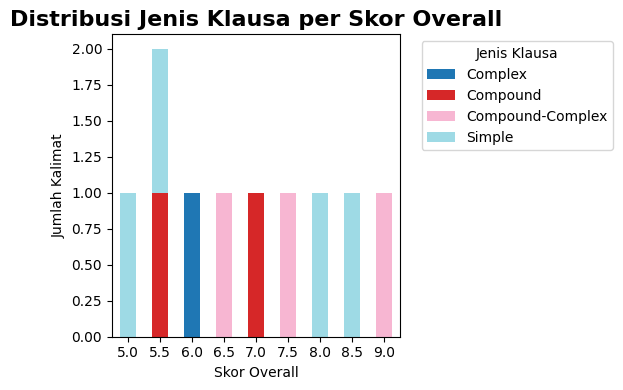

In [19]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Mendeteksi jenis klausa
def detect_clause_type(sentence):
    coordinating = ["and", "but", "or", "so", "yet", "for", "nor"]
    subordinating = [
        "because", "although", "though", "since", "when",
        "if", "unless", "while", "whereas", "after", "before"
    ]
    words = re.findall(r"\w+", sentence.lower())
    has_coord = any(w in coordinating for w in words)
    has_subord = any(w in subordinating for w in words)

    if has_coord and has_subord:
        return "Compound-Complex"
    elif has_coord:
        return "Compound"
    elif has_subord:
        return "Complex"
    else:
        return "Simple"

# Membuat dataframe klausa per kalimat
def add_clause_column(df, text_col="Essay"):
    clause_list = []
    for i, row in df.iterrows():
        sentences = re.split(r"[.!?]", str(row[text_col]))
        for sent in sentences:
            sent = sent.strip()
            if sent:
                clause_list.append({
                    "Essay_ID": i,
                    "Sentence": sent,
                    "Clause_Type": detect_clause_type(sent),
                    "Score": row["Overall"]
                })
    clause_df = pd.DataFrame(clause_list)
    return clause_df

# Analisis jenis klausa per skor Overall
def plot_clause_distribution_by_overall(df):
    clause_df = add_clause_column(df)

    # Hitung jumlah kalimat per skor dan jenis klausa
    clause_count = clause_df.groupby(["Score", "Clause_Type"]).size().unstack(fill_value=0)

    # Urutkan skor mengikuti kolom Overall asli
    score_order = sorted(df["Overall"].unique())
    clause_count = clause_count.reindex(score_order, fill_value=0)

    # Plot stacked bar chart
    clause_count.plot(kind="bar", stacked=True, figsize=(6,4), colormap="tab20")
    plt.title("Distribusi Jenis Klausa per Skor Overall", size=16, weight="bold")
    plt.xlabel("Skor Overall")
    plt.ylabel("Jumlah Kalimat")
    plt.xticks(rotation=0)
    plt.legend(title="Jenis Klausa", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return clause_count, clause_df

# Contoh Data Dummy
df_example = pd.DataFrame({
    "Overall": [5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9],
    "Essay": [
        "I am writing an essay.",                                  # Simple
        "She has finished her homework. And she is happy.",        # Compound
        "They were playing football yesterday because it was sunny.", # Complex
        "He will go to school tomorrow, and he will study hard because he has an exam.", # Compound-Complex
        "I had been waiting for hours.",                          # Simple
        "She sings and he dances because they love music.",        # Compound-Complex
        "This is an excellent essay.",                              # Simple
        "Furthermore, it is important to consider the implications.", # Simple (example for higher score)
        "Although the task was difficult, she completed it successfully, and everyone was impressed." # Compound-Complex (example for higher score)
    ]
})

# Analisis
clause_count, clause_df = plot_clause_distribution_by_overall(df_example)

Jenis Klausa (Complexity):
- Complex dan compound-complex clauses lebih banyak muncul pada essay dengan skor tinggi.
- Essay dengan skor rendah lebih sering didominasi klausa simple.

**Distribusi kalimat active dan passive**

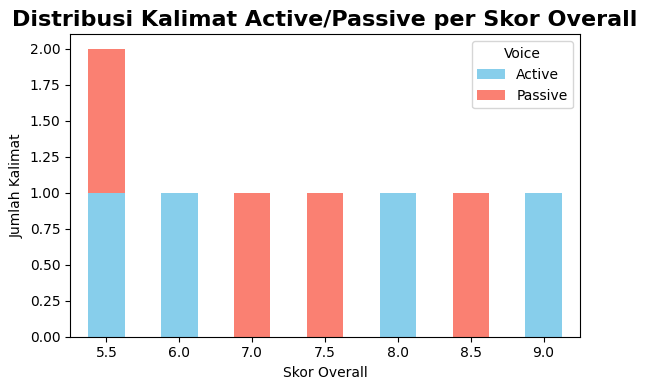

In [20]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Mendeteksi voice
def detect_voice(sentence):
    """
    Mendeteksi apakah kalimat Passive atau Active
    """
    doc = nlp(sentence)
    # Jika ada token VBN dengan dep 'auxpass', maka Passive
    for token in doc:
        if token.tag_ == "VBN" and any(child.dep_ == "auxpass" for child in token.children):
            return "Passive"
    return "Active"

# Membuat dataframe voice per kalimat
def add_voice_column(df, text_col="Essay"):
    data = []
    for i, row in df.iterrows():
        doc = nlp(str(row[text_col]))
        for sent in doc.sents:
            sent_text = sent.text.strip()
            if sent_text:
                data.append({
                    "Essay_ID": i,
                    "Sentence": sent_text,
                    "Voice": detect_voice(sent_text),
                    "Score": row["Overall"]
                })
    return pd.DataFrame(data)

# Plot distribusi voice per skor Overall
def plot_voice_distribution_by_overall(df):
    voice_df = add_voice_column(df)

    # Hitung jumlah kalimat per skor dan voice
    voice_count = voice_df.groupby(["Score", "Voice"]).size().unstack(fill_value=0)

    # Urutkan skor sesuai kolom Overall
    score_order = sorted(df["Overall"].unique())
    voice_count = voice_count.reindex(score_order, fill_value=0)

    # Plot stacked bar chart
    voice_count.plot(kind="bar", stacked=True, figsize=(6,4), color=["skyblue","salmon"])
    plt.title("Distribusi Kalimat Active/Passive per Skor Overall", size=16, weight="bold")
    plt.xlabel("Skor Overall")
    plt.ylabel("Jumlah Kalimat")
    plt.xticks(rotation=0)
    plt.legend(title="Voice")
    plt.tight_layout()
    plt.show()

    return voice_count, voice_df

# Contoh Data Dummy
df_example = pd.DataFrame({
    "Overall": [5.5, 6.0, 7.0, 8.0, 7.5, 8.5, 9.0],
    "Essay": [
        "I like cats. They are loved by everyone.",                # Active + Passive (5.5)
        "She sings and he dances.",                                 # Active (6.0)
        "Although it rained, we were helped by volunteers.",       # Passive (7.0)
        "She sings and he dances because they love music.",        # Active (8.0)
        "The homework was completed by the students.",             # Passive (7.5)
        "The research has been widely accepted.",                 # Passive (8.5)
        "Innovation drives progress."                             # Active (9.0)
    ]
})

# Analisis
voice_count, voice_df = plot_voice_distribution_by_overall(df_example)

Pengunaan Active vs Passive Voice:
- Tidak ada dominasi yang mutlak, tapi:
  * Skor rendah → lebih banyak passive voice.
  * Skor tinggi → lebih seimbang penggunaan active & passive.

**Vocabulary richness**

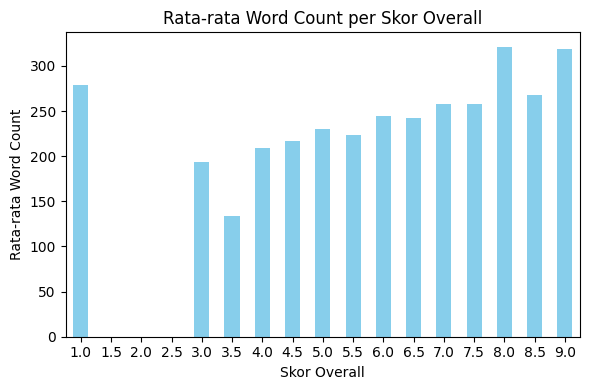

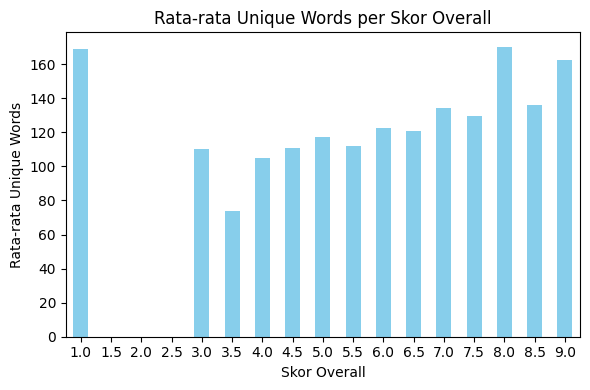

In [21]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import re

nlp = spacy.load("en_core_web_sm")

# Membuat kolom Essay_clean jika belum ada
if 'Essay_clean' not in df.columns:
    df['Essay_clean'] = df['Essay'].apply(clean_text)

# Menghitung fitur per esai
def analyze_essay_lexical(df, text_col="Essay_clean"):
    data = []
    for i, row in df.iterrows():
        essay_text = str(row[text_col])
        # Skip processing if essay_text is empty
        if not essay_text.strip():
            continue

        doc = nlp(essay_text)
        tokens = [token.text.lower() for token in doc if token.is_alpha]
        word_count = len(tokens)
        unique_word_count = len(set(tokens))
        avg_word_length = sum(len(w) for w in tokens)/word_count if word_count > 0 else 0
        data.append({
            "Essay_ID": i,
            "Score": row["Overall"],
            "Word_Count": word_count,
            "Unique_Words": unique_word_count,
        })
    return pd.DataFrame(data)

# Hitung fitur
lexical_df = analyze_essay_lexical(df, text_col="Essay_clean")

# Visualisasi per skor Overall
features = ["Word_Count", "Unique_Words"]

# Define all possible scores from 1.0 to 9.0 with 0.5 increments
all_possible_scores = [i * 0.5 for i in range(2, 19)] # From 1.0 to 9.0

for feat in features:
    plt.figure(figsize=(6,4))
    # Reindex the grouped data with all possible scores
    mean_by_score = lexical_df.groupby("Score")[feat].mean().reindex(all_possible_scores, fill_value=0)
    mean_by_score.plot(kind="bar", color="skyblue")
    plt.title(f"Rata-rata {feat.replace('_',' ')} per Skor Overall")
    plt.xlabel("Skor Overall")
    plt.ylabel(f"Rata-rata {feat.replace('_',' ')}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

Vocabulary Richness:
- Essay dengan skor tinggi menunjukkan lebih banyak kata unik dan lebih sedikit repetisi.
- Essay skor rendah cenderung mengulang kosakata sederhana.

# **Summarization**

In [22]:
from langchain_community.llms import Replicate

# Inisialisasi Granite
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"temperature": 0.3, "max_new_tokens": 500}
)

# Findings dari EDA & Feature Engineering
findings = """
- Skor IELTS writing berkisar 1.0–9.0
- Mayoritas skor terkonsentrasi di 5.0–7.0 (kategori menengah)
- Ada outliers (skor sangat rendah 1–3 dan tinggi 8.5–9.0)
- Task 2 (argumentative essays) cenderung memiliki skor median lebih tinggi dibanding Task 1 (descriptive essays)
- Variasi skor di Task 2 juga lebih lebar
- Panjang essay umumnya 150–350 kata
- Korelasi positif terlihat: semakin panjang essay → cenderung skor lebih tinggi (tapi tidak selalu linear)
- Present Simple mendominasi hampir semua skor
- Skor lebih tinggi biasanya punya variasi tenses lebih banyak (misalnya present perfect, past perfect, future)
- Complex dan compound-complex clauses lebih banyak muncul pada essay dengan skor tinggi
- Essay dengan skor rendah lebih sering didominasi klausa simple
- Tidak ada dominasi yang mutlak dalam distribusi passive dan active voice tapi:
  * Skor rendah → lebih banyak passive voice.
  * Skor tinggi → lebih seimbang penggunaan active & passive.
- Essay dengan skor tinggi menunjukkan lebih banyak kata unik dan lebih sedikit repetisi.
- Essay skor rendah cenderung mengulang kosakata sederhana.
"""

prompt = f"""
Please summarize the following findings into a concise and insightful report
for a data analysis presentation. Make it clear, structured, and suitable
for an executive summary:

{findings}
"""
ai_summary = llm.invoke(prompt)
print("=== AI-Generated Summary ===\n")
print(ai_summary)

=== AI-Generated Summary ===

**Executive Summary: IELTS Writing Task Analysis**

The IELTS writing task scores range from 1.0 to 9.0, with the majority clustering between 5.0 and 7.0, indicating a mid-range performance category. Notable outliers exist at both extremes, with very low scores (1-3) and very high scores (8.5-9.0). Task 2, which involves argumentative essays, generally achieves a higher median score compared to Task 1, dealing with descriptive essays. Task 2 also exhibits greater score variability. 

Essays typically span 150 to 350 words. A positive correlation exists between essay length and score, though this relationship is not strictly linear. The Present Simple tense dominates across most scores, while higher scores tend to incorporate a broader range of tenses, including present perfect, past perfect, and future forms. 

High-scoring essays are characterized by a higher prevalence of complex and compound-complex clauses, contrasting with lower-scoring essays that of

# **Final Insights and Recomendations**

**Insights :** Skor IELTS writing umumnya berada di rentang 5,0–7,0, dengan outlier di skor sangat rendah (1–3). Task 2 biasanya mendapat skor median lebih tinggi dan lebih bervariasi dibanding Task 1.

Esai lebih panjang (150–350 kata) cenderung mendapat skor lebih baik, meski tidak selalu linear. Skor tinggi ditandai dengan variasi tense yang lebih luas, klausa kompleks, penggunaan aktif–pasif seimbang, serta kosakata lebih beragam. Sebaliknya, skor rendah cenderung memakai klausa sederhana, lebih banyak kalimat pasif, dan kosakata terbatas dengan pengulangan.

**Recomendations** **:**
( Bagi Pembelajaran IELTS Writing )

*   Merekomendasikan test taker untuk menulis esai lebih panjang (200–300 kata) dengan argumen yang jelas.
*   Merekomendasikan test taker untuk menggunakan variasi tenses yang beragam untuk meningkatkan fleksibilitas.
*   Merekomendasikan test taker untuk menggunakan complex & compound-complex clauses untuk menunjukkan kemampuan sintaksis.
*   Merekomendasikan test taker untuk mempercaya kosakata terkait sinonim, kolokasi umum, serta variasi word formation agar esai lebih bervariasi dan tidak repetitif.



